Машинный перевод. Seq2Seq + Attention

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as func

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
SOS = 0
EOS = 1

In [0]:
class Language:
  def __init__(self, name):
    self.name = name
    self.word2index = {'SOS' : 0, 'EOS' : 1}
    self.word2count = {}
    self.index2word = {0 : 'SOS', 1 : 'EOS'}
    self.words_num = 2
  
  def new_sent(self, sent):
    for word in sent.split(' '):
      self.new_word(word)
    
  def new_word(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.words_num
      self.word2count[word] = 1
      self.index2word[self.words_num] = word
      self.words_num += 1
    else:
      self.word2count[word] += 1

In [0]:
def uni2asc(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [0]:
def norm(s):
    s = uni2asc(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
def read_lang(lang):
  lines = open('/content/gdrive/My Drive/Data/Translations/eng-%s.txt' % (lang), encoding='utf-8').read().strip().split('\n')
  pairs = []
  for line in lines:
    sents = line.split('\t')
    pairs.append([norm(sents[1]), norm(sents[0])])
  return Language(lang), Language('eng'), pairs

In [0]:
MAX_LENGTH = 10

In [0]:
eng_prefixes = ("i am", "i m", "he is", "he s", "she is", "she s", "you are", "you re", "we are", "we re", "they are", "they re")

In [0]:
def is_accepted(pair):
  return len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH and pair[1].startswith(eng_prefixes)

In [0]:
def filter_pairs(pairs):
  return [pair for pair in pairs if is_accepted(pair)]

In [0]:
def prepare_data(lang):
  SRC, TRG, PAIRS = read_lang(lang)
  print('Before: ', len(PAIRS))
  PAIRS = filter_pairs(PAIRS)
  print('After: ', len(PAIRS))
  for pair in PAIRS:
    SRC.new_sent(pair[0])
    TRG.new_sent(pair[1])
  print('SRC: ', SRC.words_num)
  print('TRG: ', TRG.words_num)
  return SRC, TRG, PAIRS

In [0]:
SRC, TRG, PAIRS = prepare_data('fra')
print(random.choice(PAIRS))

Before:  135842
After:  11893
SRC:  4920
TRG:  3228
['il faut que je sache la verite .', 'i must know the truth .']


In [0]:
class Encoder(nn.Module):
    def __init__(self, inp_dim, hid_dim):
        super(Encoder, self).__init__()
        self.hid_dim = hid_dim

        self.inp2emb = nn.Embedding(inp_dim, hid_dim)
        self.emb2hid = nn.GRU(hid_dim, hid_dim)

    def forward(self, inp, h):
        emb = self.inp2emb(inp).view(1, 1, -1)
        hid, h = self.emb2hid(emb, h)
        return hid, h

    def init_state(self):
      return torch.zeros(1, 1, self.hid_dim, device = device)

In [0]:
class DecoderUPD(nn.Module):
    def __init__(self, hid_dim, out_dim, drop = 0.1):
        super(DecoderUPD, self).__init__()
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.inp2emb = nn.Embedding(out_dim, hid_dim)
        self.ehc2wei = nn.Linear(hid_dim * 2, MAX_LENGTH)
        self.eow2emb = nn.Linear(hid_dim * 2, hid_dim)
        self.drop = nn.Dropout(drop)
        self.emb2hid = nn.GRU(hid_dim, hid_dim)
        self.hid2out = nn.Linear(hid_dim, out_dim)

    def forward(self, inp, h, enc_outs):
        emb = self.drop(self.inp2emb(inp).view(1, 1, -1))

        wei = func.softmax(self.ehc2wei(torch.cat((emb[0], h[0]), 1)), dim = 1)
        ow = torch.bmm(wei.unsqueeze(0), enc_outs.unsqueeze(0))

        eow = torch.cat((emb[0], ow[0]), 1)
        emb = func.relu(self.eow2emb(eow).unsqueeze(0))
        hid, h = self.emb2hid(emb, h)

        out = func.log_softmax(self.hid2out(hid[0]), dim = 1)
        return out, h, wei

    def init_state(self):
      return torch.zeros(1, 1, self.hid_dim, device = device)

In [0]:
def sent2ind(lang, sent):
  return [lang.word2index[word] for word in sent.split(' ')]

In [0]:
def sent2ten(lang, sent):
  ind = sent2ind(lang, sent)
  ind.append(EOS)
  return torch.tensor(ind).type(torch.LongTensor).to(device).view(-1, 1)

In [0]:
def pair2ten(pair):
  src_ten = sent2ten(SRC, pair[0])
  trg_ten = sent2ten(TRG, pair[1])
  return (src_ten, trg_ten)

In [0]:
tfr = 0.5

In [0]:
def train(src_ten, trg_ten, enc, dec, enc_opt, dec_opt, crit):  
  enc_h = enc.init_state()

  enc_opt.zero_grad()
  dec_opt.zero_grad()

  src_len = src_ten.size(0)
  trg_len = trg_ten.size(0)

  enc_outs = torch.zeros(MAX_LENGTH, enc.hid_dim, device = device)

  loss = 0

  for i in range(src_len):
    enc_out, enc_h = enc(src_ten[i], enc_h)
    enc_outs[i] = enc_out[0, 0]
  
  dec_inp = torch.tensor([[SOS]], device = device)
  dec_h = enc_h

  if random.random() < tfr:
    for i in range(trg_len):
      dec_out, dec_h, dec_wei = dec(dec_inp, dec_h, enc_outs)
      loss += crit(dec_out, trg_ten[i])
      dec_inp = trg_ten[i]
  else:
    for i in range(trg_len):
      dec_out, dec_h, dec_wei = dec(dec_inp, dec_h, enc_outs)
      _, top_ind = dec_out.topk(1)
      dec_inp = top_ind.squeeze().detach()
      loss += crit(dec_out, trg_ten[i])
      if dec_inp.item() == EOS:
        break
  
  loss.backward()
  enc_opt.step()
  dec_opt.step()

  return loss.item() / trg_len

In [0]:
import time
import math

In [0]:
def min_sec(s):
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

In [0]:
def count_time(start, percent):
  now = time.time()
  s = now - start
  es = s / (percent)
  rs = es - s
  return '%s (- %s)' % (min_sec(s), min_sec(rs))

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [0]:
plt.switch_backend('agg')

In [0]:
def show_plot(points):
  plt.figure()
  fig, axs = plt.subplots()
  loc = ticker.MultipleLocator(base = 0.2)
  axs.yaxis.set_major_locator(loc)
  plt.plot(points)

In [0]:
def train_epochs(enc, dec, epochs_num, best, print_period = 1000, plot_period = 100, lr = 0.005):
  start = time.time()
  losses = []
  print_loss_total = 0
  plot_loss_total = 0

  enc_opt = optim.SGD(enc.parameters(), lr = lr)
  dec_opt = optim.SGD(dec.parameters(), lr = lr)
  pairs = [pair2ten(random.choice(PAIRS)) for i in range(epochs_num)]
  crit = nn.NLLLoss()

  for i in range(1, epochs_num + 1):
    pair = pairs[i - 1]
    src_ten = pair[0]
    trg_ten = pair[1]

    loss = train(src_ten, trg_ten, enc, dec, enc_opt, dec_opt, crit)
    print_loss_total += loss
    plot_loss_total += loss

    if i % print_period == 0:
      period_loss = print_loss_total / print_period
      print('%s (%d %d%%) %.5f' % (count_time(start, i / epochs_num), i, i / epochs_num * 100, period_loss))
      if (period_loss < best):
        torch.save(enc.state_dict(), '/content/gdrive/My Drive/Models/fra_eng_enc.pt')
        torch.save(dec.state_dict(), '/content/gdrive/My Drive/Models/fra_eng_dec.pt')
        best = period_loss
      print_loss_total = 0
    
    if i % plot_period == 0:
      losses.append(plot_loss_total / plot_period)
      plot_loss_total = 0
    
  show_plot(losses)

In [0]:
def eval(enc, dec, sent):
  with torch.no_grad():
    src_ten = sent2ten(SRC, sent)
    src_len = src_ten.size(0)
    enc_h = enc.init_state()

    enc_outs = torch.zeros(MAX_LENGTH, enc.hid_dim, device = device)

    for i in range(src_len):
      enc_out, enc_h = enc(src_ten[i], enc_h)
      enc_outs[i] = enc_out[0, 0]
    
    dec_inp = torch.tensor([[SOS]], device = device)
    dec_h = enc_h
    
    dec_words = []
    dec_weights = torch.zeros(MAX_LENGTH, MAX_LENGTH)

    for i in range(MAX_LENGTH):
      dec_out, dec_h, dec_wei = dec(dec_inp, dec_h, enc_outs)
      dec_weights[i] = dec_wei
      top_ind = dec_out.argmax()
      dec_inp = top_ind.squeeze().detach()
      if dec_inp.item() == EOS:
        dec_words.append('<eos>')
        break
      else:
        dec_words.append(TRG.index2word[top_ind.item()])
    
  return dec_words, dec_weights[:i + 1]

In [0]:
def eval_rand(enc, dec, count):
  for i in range(count):
    pair = random.choice(PAIRS)
    print('SRC: ', pair[0])
    words, weights = eval(enc, dec, pair[0])
    print('OUT: ', ' '.join(words))
    print('TRG: ', pair[1])
    print('')

In [0]:
hid_dim = 256
enc = Encoder(SRC.words_num, hid_dim).to(device)
dec = DecoderUPD(hid_dim, TRG.words_num, 0.1).to(device)

In [0]:
train_epochs(enc, dec, 75000, float('inf'))

0m 32s (- 39m 32s) (1000 1%) 3.66388
0m 56s (- 34m 33s) (2000 2%) 3.14618
1m 21s (- 32m 39s) (3000 4%) 2.90173
1m 46s (- 31m 32s) (4000 5%) 2.80285
2m 11s (- 30m 47s) (5000 6%) 2.67741
2m 36s (- 30m 3s) (6000 8%) 2.56292
3m 1s (- 29m 25s) (7000 9%) 2.55319
3m 26s (- 28m 51s) (8000 10%) 2.47862
3m 51s (- 28m 20s) (9000 12%) 2.41384
4m 17s (- 27m 50s) (10000 13%) 2.34676
4m 42s (- 27m 22s) (11000 14%) 2.29491
5m 7s (- 26m 54s) (12000 16%) 2.20707
5m 32s (- 26m 26s) (13000 17%) 2.14106
5m 58s (- 26m 0s) (14000 18%) 2.01505
6m 23s (- 25m 33s) (15000 20%) 2.02115
6m 48s (- 25m 5s) (16000 21%) 1.99594
7m 13s (- 24m 38s) (17000 22%) 1.89343
7m 38s (- 24m 11s) (18000 24%) 1.88879
8m 3s (- 23m 44s) (19000 25%) 1.73795
8m 28s (- 23m 18s) (20000 26%) 1.76994
8m 53s (- 22m 52s) (21000 28%) 1.75230
9m 18s (- 22m 25s) (22000 29%) 1.72170
9m 43s (- 21m 58s) (23000 30%) 1.70563
10m 8s (- 21m 32s) (24000 32%) 1.70141
10m 33s (- 21m 7s) (25000 33%) 1.59329
10m 58s (- 20m 41s) (26000 34%) 1.52290
11m 23s

In [0]:
eval_rand(enc, dec, 10)

SRC:  je ne suis pas un criminel .
OUT:  i m not a criminal . <eos>
TRG:  i m not a criminal .

SRC:  ils sont propres .
OUT:  they re terrified . <eos>
TRG:  they re clean .

SRC:  tu reussiras sans aucun doute quoique tu fasses .
OUT:  you are sure to succeed . <eos>
TRG:  you are sure to succeed whatever you do .

SRC:  je suis fascinee par les chats .
OUT:  i m fascinated by cats . <eos>
TRG:  i m fascinated by cats .

SRC:  je suis content de vous revoir .
OUT:  i m glad to see you again . <eos>
TRG:  i m happy to see you again .

SRC:  il est habitue a parler en public .
OUT:  he s used to speaking in public . <eos>
TRG:  he is accustomed to speaking in public .

SRC:  ils epandent les arbres fruitiers .
OUT:  they are spraying the fruit fruit . <eos>
TRG:  they are spraying the fruit trees .

SRC:  je dois etre aveugle .
OUT:  i must be blind . <eos>
TRG:  i must be blind .

SRC:  je ne suis pas stupide a ce point !
OUT:  i m not that stupid ! <eos>
TRG:  i m not that stupid !



In [0]:
words, weights = eval(enc, dec, "j ecoute de la musique .")
print(words, weights)

['i', 'm', 'fond', 'of', 'music', '.', '<eos>'] tensor([[1.4988e-07, 9.9915e-01, 1.8028e-08, 8.5163e-04, 1.3258e-10, 1.0209e-10,
         5.6508e-11, 1.3929e-10, 1.6425e-09, 8.1524e-09],
        [3.6090e-07, 9.9999e-01, 2.3057e-06, 1.9743e-06, 2.1701e-08, 3.4333e-10,
         1.7248e-11, 1.0608e-06, 1.0737e-08, 4.1863e-07],
        [1.8286e-11, 2.6295e-10, 7.0476e-11, 1.0000e+00, 3.2631e-11, 1.1411e-14,
         1.0773e-15, 8.0951e-15, 9.8310e-11, 1.6571e-10],
        [3.9097e-13, 4.8161e-12, 2.7189e-12, 4.1288e-11, 9.9996e-01, 3.9424e-05,
         3.9655e-14, 1.5121e-19, 2.4278e-16, 1.2791e-12],
        [1.9352e-15, 2.0572e-14, 4.6520e-15, 1.4631e-17, 2.1022e-17, 1.0000e+00,
         1.6616e-08, 3.9178e-19, 8.0433e-21, 1.2410e-14],
        [1.4684e-08, 9.8460e-08, 3.0444e-08, 1.1465e-08, 3.6363e-11, 5.2426e-03,
         9.9476e-01, 1.1943e-08, 1.6020e-11, 1.1922e-07],
        [2.2702e-04, 5.9975e-04, 5.6108e-04, 1.8016e-06, 1.3786e-10, 1.4740e-06,
         2.9367e-01, 1.6864e-03, 7.03

In [0]:
enc.load_state_dict(torch.load('/content/gdrive/My Drive/Models/fra_eng_enc.pt'))
dec.load_state_dict(torch.load('/content/gdrive/My Drive/Models/fra_eng_dec.pt'))

<All keys matched successfully>

In [0]:
train_epochs(enc, dec, 25000, 0.47848)

0m 28s (- 11m 33s) (1000 4%) 0.70772
0m 54s (- 10m 30s) (2000 8%) 0.68722
1m 21s (- 9m 54s) (3000 12%) 0.69718
1m 46s (- 9m 20s) (4000 16%) 0.66020
2m 12s (- 8m 50s) (5000 20%) 0.72001
2m 38s (- 8m 21s) (6000 24%) 0.61607
3m 4s (- 7m 54s) (7000 28%) 0.68031
3m 30s (- 7m 27s) (8000 32%) 0.66103
3m 56s (- 6m 59s) (9000 36%) 0.66933
4m 21s (- 6m 32s) (10000 40%) 0.59938
4m 47s (- 6m 6s) (11000 44%) 0.59017
5m 13s (- 5m 39s) (12000 48%) 0.60790
5m 39s (- 5m 12s) (13000 52%) 0.58020
6m 5s (- 4m 46s) (14000 56%) 0.55122
6m 31s (- 4m 20s) (15000 60%) 0.55010
6m 57s (- 3m 54s) (16000 64%) 0.59615
7m 22s (- 3m 28s) (17000 68%) 0.59792
7m 48s (- 3m 2s) (18000 72%) 0.54714
8m 14s (- 2m 36s) (19000 76%) 0.52525
8m 40s (- 2m 10s) (20000 80%) 0.54752
9m 6s (- 1m 44s) (21000 84%) 0.49584
9m 32s (- 1m 18s) (22000 88%) 0.47848
9m 57s (- 0m 51s) (23000 92%) 0.51429
10m 23s (- 0m 25s) (24000 96%) 0.50147
10m 49s (- 0m 0s) (25000 100%) 0.51976


In [0]:
eval_rand(enc, dec, 10)

SRC:  je prends du poids .
OUT:  i m worried weight . <eos>
TRG:  i m gaining weight .

SRC:  vous etes invites .
OUT:  you re invited . <eos>
TRG:  you re invited .

SRC:  j ai du voir cette fille quelque part .
OUT:  i must have that that girl that . <eos>
TRG:  i may have seen that girl somewhere .

SRC:  je cherche du travail .
OUT:  i m looking for a job . <eos>
TRG:  i m looking for work .

SRC:  je suis fidele .
OUT:  i m faithful . <eos>
TRG:  i m faithful .

SRC:  elle nous enseigne le francais .
OUT:  she is teaching us french . <eos>
TRG:  she s teaching us french .

SRC:  nous sommes enfin seuls .
OUT:  we re finally alone . <eos>
TRG:  we re finally alone .

SRC:  je suis electricien .
OUT:  i am an electrician . <eos>
TRG:  i am an electrician .

SRC:  j ai toujours faim .
OUT:  i m always hungry . <eos>
TRG:  i m always hungry .

SRC:  je suis en train de fermer la porte .
OUT:  i m waiting for the door . <eos>
TRG:  i m closing the door .



In [0]:
words, weights = eval(enc, dec, "j ecoute de la musique .")
print(words, weights)

['i', 'm', 'fond', 'of', 'music', '.', '<eos>'] tensor([[1.3995e-07, 9.9993e-01, 3.0733e-08, 7.3678e-05, 2.0966e-10, 1.8812e-10,
         3.4202e-10, 1.0141e-10, 9.6102e-10, 8.2863e-09],
        [6.9116e-08, 1.0000e+00, 5.2081e-07, 3.0659e-07, 7.2632e-10, 1.4829e-10,
         1.1139e-11, 7.1705e-07, 1.5386e-09, 1.2303e-07],
        [1.7585e-11, 5.1485e-10, 1.1259e-10, 1.0000e+00, 8.3942e-12, 2.7574e-15,
         1.4427e-15, 4.5317e-14, 1.5646e-10, 1.0318e-10],
        [1.9585e-12, 2.1068e-11, 4.9467e-12, 3.4898e-10, 1.0000e+00, 2.0272e-07,
         1.5087e-13, 4.7818e-19, 1.6922e-15, 3.2139e-12],
        [1.3448e-14, 5.9677e-14, 2.7676e-14, 2.9798e-16, 3.8067e-16, 1.0000e+00,
         9.0226e-08, 2.7335e-18, 6.4279e-20, 1.1660e-13],
        [5.4041e-09, 5.0863e-08, 2.4790e-08, 2.1049e-09, 2.8602e-11, 6.0712e-05,
         9.9994e-01, 2.7010e-08, 1.5103e-11, 1.1930e-07],
        [1.5072e-05, 1.3048e-05, 1.6025e-05, 1.4273e-08, 1.7670e-12, 3.6829e-07,
         3.0911e-01, 1.2692e-05, 6.90

In [0]:
from nltk.translate.bleu_score import corpus_bleu

In [0]:
def compute_bleu(pairs):
    src_lines = []
    trg_lines = []
    
    for i in range(len(pairs)):
      src_lines.append(pairs[i][0])
      trg_lines.append(pairs[i][1])

    out_lines = []
    for src_line in src_lines:
      words, weights = eval(enc, dec, src_line)
      out_lines.append(words[:-1])
    
    trg_lines = [[trg_line.split(' ')] for trg_line in trg_lines]
    return corpus_bleu(trg_lines, out_lines) * 100

In [0]:
def get_pairs(count):
  test_pairs = []
  for i in range(count):
    test_pairs.append(random.choice(PAIRS))
  return test_pairs

In [0]:
train_epochs(enc, dec, 25000, 0.47848)

0m 27s (- 11m 7s) (1000 4%) 0.50259
0m 53s (- 10m 16s) (2000 8%) 0.53057
1m 19s (- 9m 40s) (3000 12%) 0.53614
1m 44s (- 9m 8s) (4000 16%) 0.51935
2m 10s (- 8m 40s) (5000 20%) 0.48647
2m 35s (- 8m 12s) (6000 24%) 0.45000
3m 1s (- 7m 46s) (7000 28%) 0.49148
3m 26s (- 7m 18s) (8000 32%) 0.52361
3m 52s (- 6m 52s) (9000 36%) 0.49544
4m 17s (- 6m 25s) (10000 40%) 0.50441
4m 42s (- 5m 59s) (11000 44%) 0.44737
5m 8s (- 5m 34s) (12000 48%) 0.51265
5m 34s (- 5m 8s) (13000 52%) 0.46881
5m 59s (- 4m 42s) (14000 56%) 0.47811
6m 25s (- 4m 16s) (15000 60%) 0.47000
6m 51s (- 3m 51s) (16000 64%) 0.44214
7m 18s (- 3m 26s) (17000 68%) 0.43927
7m 45s (- 3m 0s) (18000 72%) 0.42761
8m 11s (- 2m 35s) (19000 76%) 0.43548
8m 37s (- 2m 9s) (20000 80%) 0.41551
9m 4s (- 1m 43s) (21000 84%) 0.41236
9m 30s (- 1m 17s) (22000 88%) 0.47334
9m 57s (- 0m 51s) (23000 92%) 0.42178
10m 23s (- 0m 25s) (24000 96%) 0.40141
10m 49s (- 0m 0s) (25000 100%) 0.40616


In [0]:
for i in range(10):
  print(compute_bleu(get_pairs(1000)))

77.45929352480205
76.71095361127527
76.32276399840859
79.34158640418656
77.02871598626578
78.87202662845463
79.40090108999799
79.46910030038936
78.90357604750584
79.7139941920086


In [0]:
train_epochs(enc, dec, 25000, 0.40141)

0m 29s (- 11m 36s) (1000 4%) 0.40064
0m 55s (- 10m 36s) (2000 8%) 0.44823
1m 21s (- 9m 57s) (3000 12%) 0.39284
1m 48s (- 9m 28s) (4000 16%) 0.36255
2m 14s (- 8m 57s) (5000 20%) 0.40137
2m 40s (- 8m 27s) (6000 24%) 0.38101
3m 6s (- 7m 59s) (7000 28%) 0.39020
3m 32s (- 7m 32s) (8000 32%) 0.38848
3m 59s (- 7m 4s) (9000 36%) 0.35410
4m 25s (- 6m 37s) (10000 40%) 0.34033
4m 51s (- 6m 10s) (11000 44%) 0.36769
5m 17s (- 5m 43s) (12000 48%) 0.34226
5m 43s (- 5m 17s) (13000 52%) 0.36085
6m 9s (- 4m 50s) (14000 56%) 0.40239
6m 36s (- 4m 24s) (15000 60%) 0.36801
7m 2s (- 3m 57s) (16000 64%) 0.37183
7m 29s (- 3m 31s) (17000 68%) 0.33406
7m 56s (- 3m 5s) (18000 72%) 0.38160
8m 22s (- 2m 38s) (19000 76%) 0.36906
8m 48s (- 2m 12s) (20000 80%) 0.35353
9m 15s (- 1m 45s) (21000 84%) 0.33359
9m 40s (- 1m 19s) (22000 88%) 0.32796
10m 6s (- 0m 52s) (23000 92%) 0.33565
10m 31s (- 0m 26s) (24000 96%) 0.37004
10m 57s (- 0m 0s) (25000 100%) 0.35714


In [0]:
enc.load_state_dict(torch.load('/content/gdrive/My Drive/Models/fra_eng_enc.pt'))
dec.load_state_dict(torch.load('/content/gdrive/My Drive/Models/fra_eng_dec.pt'))

<All keys matched successfully>

In [0]:
for i in range(10):
  print(compute_bleu(get_pairs(1000)))

80.48156928622919
81.24753205363798
79.81273788751616
81.0296051357772
79.34616450530855
79.59164814741696
80.77374025907955
82.29567801625682
80.42838877181444
81.92432142262327


In [0]:
%matplotlib inline

['i', 'm', 'not', 'a', 'native', 'speaker', '.', '<eos>'] 
 tensor([[1.7361e-13, 1.0000e+00, 1.1411e-14, 1.2162e-14, 1.2065e-18, 1.0640e-13,
         2.3425e-13, 2.1547e-19, 1.5397e-17, 5.2904e-15],
        [5.8555e-09, 1.0000e+00, 1.0916e-08, 7.0129e-07, 6.5618e-12, 5.9140e-13,
         5.8467e-09, 5.6987e-13, 1.6252e-11, 1.9167e-08],
        [5.0111e-14, 2.8661e-12, 1.7706e-13, 1.0000e+00, 1.4785e-15, 1.7353e-18,
         1.4034e-15, 1.2616e-18, 2.0496e-14, 5.1540e-13],
        [5.8945e-14, 8.0699e-15, 9.7441e-14, 5.6320e-10, 3.0156e-12, 1.0000e+00,
         1.3543e-14, 8.4769e-22, 5.3062e-15, 3.3653e-14],
        [1.4450e-13, 1.1877e-14, 2.3211e-13, 5.8418e-15, 3.2433e-11, 6.8858e-07,
         1.0000e+00, 7.2838e-21, 1.3684e-15, 1.2986e-12],
        [2.2877e-15, 1.6089e-16, 2.3439e-14, 7.4209e-18, 3.0798e-26, 1.7260e-08,
         1.0000e+00, 8.2226e-15, 3.3534e-17, 1.6529e-13],
        [1.7448e-14, 9.2711e-16, 8.0512e-14, 2.2268e-16, 1.8505e-25, 1.1117e-21,
         1.0000e+00, 2.07

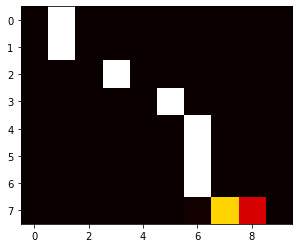

In [0]:
words, weights = eval(enc, dec, "je ne suis pas un locuteur natif .")
print(words, '\n', weights)
plt.imshow(weights, cmap='hot')
plt.show()

['i', 'm', 'not', 'a', 'violent', 'person', '.', '<eos>'] 
 tensor([[1.5350e-12, 1.0000e+00, 8.0879e-14, 1.4954e-15, 1.6910e-17, 3.4484e-14,
         1.3949e-16, 7.0670e-16, 4.4552e-14, 6.0762e-14],
        [6.9071e-08, 1.0000e+00, 1.1534e-07, 7.2723e-08, 4.1744e-10, 2.0196e-11,
         3.3352e-09, 6.3810e-10, 1.0414e-09, 2.1170e-07],
        [1.8236e-11, 4.7625e-10, 6.4808e-11, 1.0000e+00, 3.1458e-12, 2.7276e-16,
         3.2053e-14, 1.2948e-13, 2.2546e-11, 1.9599e-10],
        [2.6939e-15, 6.7388e-16, 3.3727e-15, 1.9265e-14, 9.6487e-13, 1.0000e+00,
         2.3233e-18, 9.9660e-22, 4.7653e-16, 1.4079e-15],
        [2.9568e-15, 2.6609e-18, 3.0062e-15, 2.8502e-19, 3.2256e-17, 6.1428e-10,
         1.0000e+00, 2.1470e-18, 1.6572e-17, 5.1640e-15],
        [3.9105e-11, 3.1337e-11, 2.2926e-10, 1.5292e-13, 1.1515e-21, 3.8922e-10,
         9.9999e-01, 1.2244e-05, 6.9190e-13, 6.3113e-10],
        [1.4286e-10, 9.0745e-11, 8.7144e-10, 1.1638e-15, 1.9132e-23, 5.1141e-13,
         6.1314e-01, 3.86

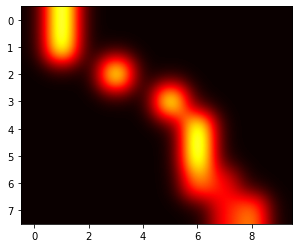

In [0]:
words, weights = eval(enc, dec, "je ne suis pas une personne violente")
print(words, '\n', weights)
plt.imshow(weights, cmap='hot', interpolation='gaussian')
plt.show()

0m 28s (- 11m 27s) (1000 4%) 0.32046
0m 53s (- 10m 18s) (2000 8%) 0.33811
1m 19s (- 9m 42s) (3000 12%) 0.34281
1m 44s (- 9m 9s) (4000 16%) 0.31913
2m 10s (- 8m 42s) (5000 20%) 0.31994
2m 36s (- 8m 15s) (6000 24%) 0.35601
3m 1s (- 7m 47s) (7000 28%) 0.32426
3m 27s (- 7m 21s) (8000 32%) 0.31925
3m 53s (- 6m 55s) (9000 36%) 0.30392
4m 19s (- 6m 29s) (10000 40%) 0.31421
4m 45s (- 6m 2s) (11000 44%) 0.33814
5m 10s (- 5m 36s) (12000 48%) 0.29083
5m 36s (- 5m 10s) (13000 52%) 0.30666
6m 1s (- 4m 44s) (14000 56%) 0.33399
6m 26s (- 4m 17s) (15000 60%) 0.29838
6m 52s (- 3m 52s) (16000 64%) 0.28918
7m 18s (- 3m 26s) (17000 68%) 0.29311
7m 43s (- 3m 0s) (18000 72%) 0.28076
8m 9s (- 2m 34s) (19000 76%) 0.28058
8m 35s (- 2m 8s) (20000 80%) 0.26165
9m 1s (- 1m 43s) (21000 84%) 0.23247
9m 27s (- 1m 17s) (22000 88%) 0.27292
9m 52s (- 0m 51s) (23000 92%) 0.30931
10m 18s (- 0m 25s) (24000 96%) 0.29128
10m 43s (- 0m 0s) (25000 100%) 0.31693


<Figure size 432x288 with 0 Axes>

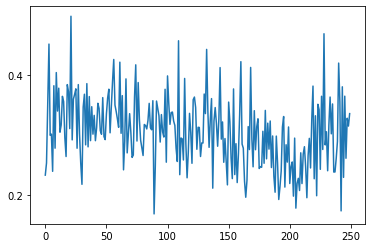

In [0]:
train_epochs(enc, dec, 25000, 0.32796)

In [0]:
for i in range(10):
  print(compute_bleu(get_pairs(1000)))

85.13369912490194
85.06015161967251
84.67699111163611
85.11748228880566
84.76673161872029
84.69983547191462
84.54496206008216
83.71412665338288
85.04526996519233
85.35238203046079


In [0]:
enc.load_state_dict(torch.load('/content/gdrive/My Drive/Models/fra_eng_enc.pt'))
dec.load_state_dict(torch.load('/content/gdrive/My Drive/Models/fra_eng_dec.pt'))

<All keys matched successfully>

In [0]:
train_epochs(enc, dec, 25000, 0.23247)

0m 31s (- 12m 38s) (1000 4%) 0.27006
1m 0s (- 11m 31s) (2000 8%) 0.25749
1m 28s (- 10m 51s) (3000 12%) 0.21207
1m 57s (- 10m 18s) (4000 16%) 0.19526
2m 26s (- 9m 46s) (5000 20%) 0.22078
2m 55s (- 9m 14s) (6000 24%) 0.19934
3m 22s (- 8m 41s) (7000 28%) 0.19206
3m 51s (- 8m 11s) (8000 32%) 0.19896
4m 19s (- 7m 41s) (9000 36%) 0.19973
4m 47s (- 7m 10s) (10000 40%) 0.16981
5m 14s (- 6m 40s) (11000 44%) 0.17205
5m 42s (- 6m 11s) (12000 48%) 0.16185
6m 10s (- 5m 41s) (13000 52%) 0.14849
6m 38s (- 5m 13s) (14000 56%) 0.15631
7m 6s (- 4m 44s) (15000 60%) 0.15605
7m 34s (- 4m 15s) (16000 64%) 0.16348
8m 2s (- 3m 46s) (17000 68%) 0.13074
8m 30s (- 3m 18s) (18000 72%) 0.16363
8m 58s (- 2m 49s) (19000 76%) 0.12610
9m 26s (- 2m 21s) (20000 80%) 0.13577
9m 53s (- 1m 53s) (21000 84%) 0.12765
10m 21s (- 1m 24s) (22000 88%) 0.12751
10m 48s (- 0m 56s) (23000 92%) 0.12812
11m 16s (- 0m 28s) (24000 96%) 0.12455
11m 43s (- 0m 0s) (25000 100%) 0.12475


In [0]:
for i in range(10):
  print(compute_bleu(get_pairs(1000)))

93.83723411110697
94.10069943999255
94.46561509653937
93.47019952966868
93.293885006117
94.04983017370925
93.31619504988748
93.0358200626178
94.33155240157016
93.84632608618254


In [0]:
train_epochs(enc, dec, 50000, 0.12455)

0m 34s (- 28m 26s) (1000 2%) 0.13114
1m 3s (- 25m 17s) (2000 4%) 0.12296
1m 31s (- 23m 59s) (3000 6%) 0.11711
2m 1s (- 23m 11s) (4000 8%) 0.11108
2m 29s (- 22m 27s) (5000 10%) 0.10261
2m 58s (- 21m 49s) (6000 12%) 0.11727
3m 27s (- 21m 12s) (7000 14%) 0.10453
3m 55s (- 20m 37s) (8000 16%) 0.12904
4m 24s (- 20m 2s) (9000 18%) 0.11334
4m 52s (- 19m 29s) (10000 20%) 0.11384
5m 20s (- 18m 56s) (11000 22%) 0.11846
5m 48s (- 18m 24s) (12000 24%) 0.11561
6m 17s (- 17m 54s) (13000 26%) 0.10244
6m 45s (- 17m 23s) (14000 28%) 0.11148
7m 14s (- 16m 53s) (15000 30%) 0.11176
7m 42s (- 16m 22s) (16000 32%) 0.10517
8m 10s (- 15m 52s) (17000 34%) 0.07641
8m 39s (- 15m 22s) (18000 36%) 0.10193
9m 7s (- 14m 52s) (19000 38%) 0.10796
9m 35s (- 14m 23s) (20000 40%) 0.10493
10m 3s (- 13m 53s) (21000 42%) 0.09405
10m 31s (- 13m 23s) (22000 44%) 0.10463
11m 0s (- 12m 55s) (23000 46%) 0.10278
11m 28s (- 12m 25s) (24000 48%) 0.08785
11m 56s (- 11m 56s) (25000 50%) 0.09861
12m 24s (- 11m 27s) (26000 52%) 0.09381

In [0]:
eval_rand(enc, dec, 10)

SRC:  tu n es pas encore mort .
OUT:  you re not dead yet . <eos>
TRG:  you re not dead yet .

SRC:  je vais vous conter un secret .
OUT:  i m going to tell you a secret . <eos>
TRG:  i m going to tell you a secret .

SRC:  il est mon collegue .
OUT:  he is my colleague . <eos>
TRG:  he is my colleague .

SRC:  tu m as beaucoup manque hier .
OUT:  i missed you very much yesterday . <eos>
TRG:  i missed you very much yesterday .

SRC:  je suis plus petite que vous .
OUT:  i m shorter than you . <eos>
TRG:  i am shorter than you .

SRC:  vous etes charmante .
OUT:  you re charming . <eos>
TRG:  you re charming .

SRC:  je prends mon livre avec moi .
OUT:  i m taking my book with me . <eos>
TRG:  i m taking my book with me .

SRC:  il se tient sur la scene .
OUT:  he is standing on the stage . <eos>
TRG:  he is standing on the stage .

SRC:  je suis la patronne .
OUT:  i m the boss . <eos>
TRG:  i m the boss .

SRC:  je l ai confondu avec son frere .
OUT:  i mistook him for his brother . 

In [0]:
words, weights = eval(enc, dec, "je ne suis pas une personne violente")
print(words, '\n', weights)
plt.imshow(weights, cmap='hot', interpolation='gaussian')
plt.show()

['i', 'm', 'not', 'a', 'violent', 'person', '.', '<eos>'] 
 tensor([[2.8259e-12, 1.0000e+00, 1.3670e-13, 4.6106e-14, 4.4718e-17, 2.1443e-16,
         1.5342e-15, 1.8121e-14, 7.4022e-14, 5.5375e-14],
        [4.9678e-08, 1.0000e+00, 8.2648e-08, 2.3591e-07, 7.5701e-11, 1.2023e-12,
         1.1178e-09, 1.9283e-09, 1.7391e-09, 6.7069e-07],
        [6.2079e-11, 6.5038e-10, 1.4198e-10, 1.0000e+00, 1.6828e-11, 5.3592e-17,
         3.1500e-16, 5.2020e-12, 6.7373e-10, 6.3833e-10],
        [5.2341e-13, 5.0210e-14, 6.3395e-13, 6.7313e-13, 1.1780e-10, 1.0000e+00,
         4.4098e-16, 1.4622e-18, 1.8451e-12, 3.3676e-13],
        [1.6841e-15, 1.0283e-17, 2.0715e-15, 1.7006e-20, 4.4717e-17, 6.9402e-10,
         1.0000e+00, 4.3036e-19, 7.6543e-18, 7.5169e-15],
        [1.4336e-13, 5.7236e-14, 1.6937e-12, 6.9973e-16, 3.9709e-25, 9.9799e-13,
         1.0000e+00, 3.8352e-08, 1.4273e-16, 4.5759e-12],
        [1.0321e-12, 5.5981e-13, 4.4739e-12, 1.7437e-16, 4.1832e-26, 1.2958e-18,
         8.7094e-07, 1.00

In [0]:
enc.load_state_dict(torch.load('/content/gdrive/My Drive/Models/fra_eng_enc.pt'))
dec.load_state_dict(torch.load('/content/gdrive/My Drive/Models/fra_eng_dec.pt'))

<All keys matched successfully>

In [0]:
torch.save(enc.state_dict(), '/content/gdrive/My Drive/Models/fra_eng_enc_.pt')
torch.save(dec.state_dict(), '/content/gdrive/My Drive/Models/fra_eng_dec_.pt')

In [0]:
for i in range(10):
  print(compute_bleu(get_pairs(1000)))

95.74807363011291
95.43906687259691
95.76300729728314
95.77259711040614
96.12381774254585
94.68686163135982
95.98501990521231
95.39292721606519
96.28582909654124
95.30570963896376


In [0]:
words, weights = eval(enc, dec, "je vais acheter une nouvelle voiture")
print(words, '\n', weights)
plt.imshow(weights, cmap='hot', interpolation='gaussian')
plt.show()

['i', 'am', 'going', 'to', 'buy', 'a', 'new', 'car', '.', '<eos>'] 
 tensor([[8.0972e-12, 1.0000e+00, 1.6956e-12, 5.6113e-12, 1.0821e-12, 8.3400e-13,
         1.7323e-16, 9.6491e-18, 1.2352e-14, 1.0480e-12],
        [2.1297e-08, 9.9998e-01, 3.5217e-08, 1.9239e-05, 1.8933e-08, 1.5393e-08,
         3.6447e-12, 9.3333e-14, 5.2017e-13, 1.0666e-06],
        [2.5606e-12, 9.9141e-10, 1.0899e-11, 1.0000e+00, 4.5546e-13, 1.2092e-10,
         7.2058e-22, 8.9178e-22, 2.2635e-12, 1.9555e-11],
        [1.9322e-15, 4.5619e-14, 3.4363e-15, 2.7680e-10, 1.0000e+00, 3.1757e-12,
         1.0814e-15, 5.8844e-23, 4.1971e-19, 1.3311e-15],
        [4.7470e-15, 1.4948e-13, 1.4796e-14, 1.0552e-16, 3.0452e-11, 1.0000e+00,
         6.3128e-14, 6.6121e-23, 1.5929e-16, 5.7626e-14],
        [1.2573e-08, 5.8852e-10, 5.1402e-08, 4.9025e-10, 1.6009e-06, 9.9813e-01,
         1.8725e-03, 2.4104e-14, 9.3354e-12, 2.2485e-07],
        [6.2747e-08, 3.0351e-09, 1.7942e-07, 1.5656e-09, 1.5320e-03, 2.0166e-01,
         7.9680e